In [1]:
!pip install -U sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.7 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=d1010e6a2e96fc9d445424ad94aed521926f9e81529ebc9770c5c2c6b58d5d29
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [2]:
import numpy as np
# data processing, CSV file I / O (e.g. pd.read_csv)
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.layers import Flatten, Dense, LSTM, Dropout, Embedding, Activation
from keras.layers import concatenate, BatchNormalization, Input
from keras.layers import add
from keras.utils import to_categorical, plot_model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import matplotlib.pyplot as plt  # for plotting data
import cv2
import string
from tensorflow.keras import backend as K
from tensorflow.keras.layers import GRU
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from PIL import Image
import sys
import pickle as pkl

Code based on https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/22_Image_Captioning.ipynb

In [3]:
from google.colab import drive
drive.mount("/content/drive")
%cd '/content/drive/MyDrive/Personal/Project/image_captioning_trainable'

Mounted at /content/drive
/content/drive/MyDrive/Personal/Project/image_captioning_trainable


In [4]:
df = pd.read_csv('Kaggle data/final_data.csv')
df.head()

,id,title,ingredients,instructions,image_name,cleaned_ingredients,ingredients_rawmats,partition
0,0,Miso-Butter Roast Chicken With Acorn Squash Pa...,"['1 (3Â½â€“4-lb.) whole chicken', '2Â¾ tsp. ko...","Pat chicken dry with paper towels, season all ...",miso-butter-roast-chicken-acorn-squash-panzanella,"['1 (3Â½â€“4-lb.) whole chicken', '2Â¾ tsp. ko...","['squash', 'oil', 'apples', 'onion', 'bread', ...",train
1,1,Crispy Salt and Pepper Potatoes,"['2 large egg whites', '1 pound new potatoes (...",Preheat oven to 400Â°F and line a rimmed bakin...,crispy-salt-and-pepper-potatoes-dan-kluger,"['2 large egg whites', '1 pound new potatoes (...","['pepper', 'salt', 'egg', 'potatoes']",train
2,2,Thanksgiving Mac and Cheese,"['1 cup evaporated milk', '1 cup whole milk', ...",Place a rack in middle of oven; preheat to 400...,thanksgiving-mac-and-cheese-erick-williams,"['1 cup evaporated milk', '1 cup whole milk', ...","['onion', 'garlic', 'pepper', 'cheese', 'chedd...",train
3,3,Italian Sausage and Bread Stuffing,"['1 (Â¾- to 1-pound) round Italian loaf, cut i...",Preheat oven to 350Â°F with rack in middle. Ge...,italian-sausage-and-bread-stuffing-240559,"['1 (Â¾- to 1-pound) round Italian loaf, cut i...","['oil', 'garlic', 'turkey', 'butter', 'eggs', ...",train
4,4,Newton's Law,"['1 teaspoon dark brown sugar', '1 teaspoon ho...",Stir together brown sugar and hot water in a c...,newtons-law-apple-bourbon-cocktail,"['1 teaspoon dark brown sugar', '1 teaspoon ho...","['cinnamon', 'bourbon', 'apple', 'juice', 'but...",train


In [5]:
def load_description(data):
	mapping = dict()
	for index, row in data.iterrows():
		mapping[row['image_name']] = row['title']
	return mapping

descriptions = load_description(df)
print(descriptions['miso-butter-roast-chicken-acorn-squash-panzanella'])


Miso-Butter Roast Chicken With Acorn Squash Panzanella


In [6]:
def clean_description(desc):
	for img_name, title in desc.items():
		caption = [ch for ch in title if ch not in string.punctuation]
		caption = ''.join(caption)
		caption = caption.split(' ')
		caption = [word.lower() for word in caption if len(word)>1 and word.isalpha()]
		caption = ' '.join(caption)
		desc[img_name] = caption

clean_description(descriptions)
descriptions['miso-butter-roast-chicken-acorn-squash-panzanella']

'misobutter roast chicken with acorn squash panzanella'

In [7]:
def to_vocab(desc):
    words = set()
    for key in desc.keys():
        for line in desc[key]:
            words.update(line.split())
    return words
vocab = to_vocab(descriptions)

In [8]:
import glob
images = '../Kaggle data/images/train/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')
len(img)

6062

In [9]:
img[0:5]

['../Kaggle data/images/train/vodka-spiked-cherry-tomatoes-with-pepper-salt-354490.jpg',
 '../Kaggle data/images/train/spicy-adobo-shrimp-cocktail-354493.jpg',
 '../Kaggle data/images/train/plum-kuchen-354489.jpg',
 '../Kaggle data/images/train/tangy-frozen-greek-yogurt-354476.jpg',
 '../Kaggle data/images/train/grilled-herb-potatoes-354496.jpg']

In [10]:
descriptions.items()

dict_items([('miso-butter-roast-chicken-acorn-squash-panzanella', 'misobutter roast chicken with acorn squash panzanella'), ('crispy-salt-and-pepper-potatoes-dan-kluger', 'crispy salt and pepper potatoes'), ('thanksgiving-mac-and-cheese-erick-williams', 'thanksgiving mac and cheese'), ('italian-sausage-and-bread-stuffing-240559', 'italian sausage and bread stuffing'), ('newtons-law-apple-bourbon-cocktail', 'newtons law'), ('warm-comfort-tequila-chamomile-toddy', 'warm comfort'), ('apples-and-oranges-spiked-cider', 'apples and oranges'), ('turmeric-hot-toddy-claire-sprouse', 'turmeric hot toddy'), ('instant-pot-lamb-haleem', 'instant pot lamb haleem'), ('spiced-lentil-and-caramelized-onion-baked-eggs', 'spiced lentil and caramelized onion baked eggs'), ('hot-pimento-cheese-dip-polina-chesnakova', 'hot pimento cheese dip'), ('spiral-ham-in-the-slow-cooker-guarnaschelli', 'spiral ham in the slow cooker'), ('butternut-squash-apple-soup-365210', 'butternut squash and apple soup'), ('caesar-

In [11]:
#train_img = img[0:5]
train_img = img

# load descriptions of training set in a dictionary. Name of the image will act as ey
def load_clean_descriptions(des, dataset):
	dataset_des = dict()
	for img_name, title in des.items():
		if '../Kaggle data/images/train/' + img_name + '.jpg' in dataset:
			dataset_des[img_name] = title
	return dataset_des

train_descriptions = load_clean_descriptions(descriptions, train_img)
print(len(train_descriptions))

6062


In [12]:
image_model = VGG16(include_top=True, weights='imagenet')

553467096/553467096 [==============================] - 26s 0us/step


In [13]:
transfer_layer = image_model.get_layer('fc2')

In [14]:
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

In [15]:
img_size = K.int_shape(image_model.input)[1:3]
img_size

(224, 224)

In [16]:
transfer_values_size = K.int_shape(transfer_layer.output)[1]
transfer_values_size

4096

In [17]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

In [18]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)
    print(f"{path}: {img.shape}")

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

In [ ]:
for filename in train_img:
  img = Image.open(filename)
  img = np.array(img)
  if len(img.shape) !=3:
    print(f"{filename}: {img.shape}")
    continue
  if img.shape[2]!=3:
    print(f"{filename}: {img.shape}")

../Kaggle data/images/train/pan-seared-salmon-on-baby-arugula-242445.jpg: (722, 702, 4)
../Kaggle data/images/train/patti-labelle-style-sweet-potato-pie.jpg: (169, 274, 4)
../Kaggle data/images/train/beef-picadillo-puffy-tacos.jpg: (169, 274, 4)
../Kaggle data/images/train/crispy-turmeric-and-pepper-baked-chicken-wings.jpg: (169, 274)
../Kaggle data/images/train/salsa-de-arbol.jpg: (169, 274)
../Kaggle data/images/train/fancy-cranberry-sauce.jpg: (169, 274)
../Kaggle data/images/train/glazed-leeks-with-pine-nut-salsa-verde.jpg: (169, 274)
../Kaggle data/images/train/sesame-scallion-chicken-salad.jpg: (169, 274)


In [19]:
train_img.remove('../Kaggle data/images/train/pan-seared-salmon-on-baby-arugula-242445.jpg')
train_img.remove('../Kaggle data/images/train/patti-labelle-style-sweet-potato-pie.jpg')
train_img.remove('../Kaggle data/images/train/beef-picadillo-puffy-tacos.jpg')
train_img.remove('../Kaggle data/images/train/crispy-turmeric-and-pepper-baked-chicken-wings.jpg')
train_img.remove('../Kaggle data/images/train/salsa-de-arbol.jpg')
train_img.remove('../Kaggle data/images/train/fancy-cranberry-sauce.jpg')
train_img.remove('../Kaggle data/images/train/glazed-leeks-with-pine-nut-salsa-verde.jpg')
train_img.remove('../Kaggle data/images/train/sesame-scallion-chicken-salad.jpg')

In [20]:
train_descriptions = load_clean_descriptions(descriptions, train_img)
print(len(train_descriptions))

6054


In [21]:
def process_images(data_dir, filenames, batch_size=32):
    """
    Process all the given files in the given data_dir using the
    pre-trained image-model and return their transfer-values.

    Note that we process the images in batches to save
    memory and improve efficiency on the GPU.
    """

    # Number of images to process.
    num_images = len(filenames)
    print(num_images)

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    # Initialize index into the filenames.
    start_index = 0

    # Process batches of image-files.
    while start_index < num_images:
        # Print the percentage-progress.
        print_progress(count=start_index, max_count=num_images)

        # End-index for this batch.
        end_index = start_index + batch_size

        # Ensure end-index is within bounds.
        if end_index > num_images:
            end_index = num_images

        # The last batch may have a different batch-size.
        current_batch_size = end_index - start_index

        # Load all the images in the batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            # Path for the image-file.
            # path = os.path.join(data_dir, filename)

            # Load and resize the image.
            # This returns the image as a numpy-array.
            img = load_image(filename, size=img_size)

            # Save the image for later use.
            image_batch[i] = img

        # Use the pre-trained image-model to process the image.
        # Note that the last batch may have a different size,
        # so we only use the relevant images.
        transfer_values_batch = \
            image_model_transfer.predict(image_batch[0:current_batch_size])

        # Save the transfer-values in the pre-allocated array.
        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    # Print newline.
    print()

    return transfer_values

In [ ]:
transfer_values = process_images(train_descriptions, train_img, batch_size=32)

Streaming output truncated to the last 5000 lines.
../Kaggle data/images/train/emergency-ginerator-363342.jpg: (224, 224, 3)
../Kaggle data/images/train/almond-apricot-chicken-with-mint-pesto-363323.jpg: (224, 224, 3)
../Kaggle data/images/train/herb-grilled-salmon-with-fresh-tomato-orange-chutney-363359.jpg: (224, 224, 3)
../Kaggle data/images/train/barbecued-chicken-and-chickpea-quesadillas-363314.jpg: (224, 224, 3)
../Kaggle data/images/train/rum-raisin-shortbread-363335.jpg: (224, 224, 3)
../Kaggle data/images/train/chocolate-praline-cake-in-a-jar-363313.jpg: (224, 224, 3)
../Kaggle data/images/train/pan-roasted-pork-chops-with-yellow-pepper-mole-sauce-363310.jpg: (224, 224, 3)
../Kaggle data/images/train/moroccan-lamb-with-tabbouleh-and-crispy-garlic-363297.jpg: (224, 224, 3)
1/1 [==============================] - 0s 37ms/step
- Progress: 20.1%../Kaggle data/images/train/spaghetti-with-walnuts-and-anchovies-363303.jpg: (224, 224, 3)
../Kaggle data/images/train/ipanema-punch-363306

In [ ]:
transfer_values

array([[0.1344, 0.1818, 1.348 , ..., 0.    , 0.    , 1.034 ],
       [0.    , 0.    , 1.242 , ..., 0.    , 0.    , 0.5957],
       [0.    , 0.    , 1.317 , ..., 0.    , 0.    , 0.95  ],
       ...,
       [0.    , 0.    , 1.398 , ..., 0.    , 0.    , 1.047 ],
       [0.    , 0.    , 1.809 , ..., 0.    , 0.    , 0.554 ],
       [0.    , 0.    , 1.582 , ..., 0.    , 0.    , 1.041 ]],
      dtype=float16)

In [ ]:
with open('transfer_values_train.pkl','wb') as f: pkl.dump(transfer_values, f)

In [ ]:
val_images = '../Kaggle data/images/val/'
# Create a list of all image names in the directory
val_img = glob.glob(val_images + '*.jpg')
len(val_img)

1978

In [ ]:
for filename in val_img:
  img = Image.open(filename)
  img = np.array(img)
  if img.shape[2] !=3:
    print(f"{filename}: {img.shape}")

In [ ]:
val_img.remove('../Kaggle data/images/val/dakgangjeong-korean-sweet-crunchy-fried-chicken-maangchi.jpg')
val_img.remove('../Kaggle data/images/val/citrus-jerk-bass-fish-with-fonio.jpg')

In [ ]:
# load descriptions of training set in a dictionary. Name of the image will act as ey
def load_clean_descriptions_val(des, dataset):
	dataset_des = dict()
	for img_name, title in des.items():
		if '../Kaggle data/images/val/' + img_name + '.jpg' in dataset:
			dataset_des[img_name] = title
	return dataset_des

val_descriptions = load_clean_descriptions_val(descriptions, val_img)
print(len(val_descriptions))

1976


In [ ]:
transfer_values_val = process_images(val_descriptions, val_img, batch_size=32)

1976
- Progress: 0.0%../Kaggle data/images/val/standing-rib-roast-with-aioli-51205480.jpg: (224, 224, 3)
../Kaggle data/images/val/slow-cooked-short-ribs-with-gremolata-51205070.jpg: (224, 224, 3)
../Kaggle data/images/val/fregola-with-clams-51205100.jpg: (224, 224, 3)
../Kaggle data/images/val/boudin-blanc-stuffed-turkey-breasts-with-chestnuts-51205440.jpg: (224, 224, 3)
../Kaggle data/images/val/spicy-glazed-pork-ribs-51205120.jpg: (224, 224, 3)
../Kaggle data/images/val/crispy-chicken-breasts-with-chermoula-and-escarole-51205310.jpg: (224, 224, 3)
../Kaggle data/images/val/caramel-layered-dark-chocolate-brownies-51203870.jpg: (224, 224, 3)
../Kaggle data/images/val/puerto-rican-coconut-eggnog-em-coquito-em-51203620.jpg: (224, 224, 3)
../Kaggle data/images/val/lemon-custard-with-raspberry-sauce-51201810.jpg: (224, 224, 3)
../Kaggle data/images/val/caramel-rice-pudding-51202420.jpg: (224, 224, 3)
../Kaggle data/images/val/fried-ipswich-whole-belly-clams-with-tartar-sauce-51201220.jpg:

In [ ]:
with open('transfer_values_val.pkl','wb') as f: pkl.dump(transfer_values_val, f)

In [ ]:
transfer_values.shape

(6059, 4096)

In [71]:
test_images = '../Kaggle data/images/test/'
# Create a list of all image names in the directory
test_img = glob.glob(test_images + '*.jpg')
len(test_img)

2010

In [ ]:
for filename in test_img:
  img = Image.open(filename)
  img = np.array(img)
  if len(img.shape) !=3:
    print(f"{filename}: {img.shape}")
    continue
  if img.shape[2]!=3:
    print(f"{filename}: {img.shape}")


../Kaggle data/images/test/broccolini-with-sesame-sauce-and-lemon.jpg: (169, 274)
../Kaggle data/images/test/creamsicle-macaroons.jpg: (169, 274)


In [72]:
test_img.remove('../Kaggle data/images/test/broccolini-with-sesame-sauce-and-lemon.jpg')
test_img.remove('../Kaggle data/images/test/creamsicle-macaroons.jpg')

In [73]:
def load_clean_descriptions_test(des, dataset):
	dataset_des = dict()
	for img_name, title in des.items():
		if '../Kaggle data/images/test/' + img_name + '.jpg' in dataset:
			dataset_des[img_name] = title
	return dataset_des

test_descriptions = load_clean_descriptions_test(descriptions, test_img)
print(len(test_descriptions))

2008


Tokenizer

In [22]:
mark_start = 'ssss '
mark_end = ' eeee'

In [23]:
train_descriptions_marked = {}
caption_list = []
for k, v in train_descriptions.items():
  train_descriptions_marked[k] = mark_start + v + mark_end
  caption_list.append(train_descriptions_marked[k])

In [24]:
caption_list_flatten = [word for line in caption_list for word in line.split()]

In [25]:
num_words = 10000

In [26]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""

    def __init__(self, texts, num_words=None):
        """
        :param texts: List of strings with the data-set.
        :param num_words: Max number of words to use.
        """

        Tokenizer.__init__(self, num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]

        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text

    def captions_to_tokens(self, captions_listlist):
        """
        Convert a list-of-list with text-captions to
        a list-of-list of integer-tokens.
        """

        # Note that text_to_sequences() takes a list of texts.
        # tokens = [self.texts_to_sequences(captions_list)
        #           for captions_list in captions_listlist]
        tokens = self.texts_to_sequences(captions_listlist)

        return tokens

In [27]:
tokenizer = TokenizerWrap(texts=caption_list_flatten,
                          num_words=num_words)

In [28]:
token_start = tokenizer.word_index[mark_start.strip()]
token_start

1

In [29]:
token_end = tokenizer.word_index[mark_end.strip()]
token_end

2

In [30]:
token_dic = {}
for k, v in train_descriptions_marked.items():
  token_dic[k] = tokenizer.captions_to_tokens([v])[0]

In [31]:
train_img[2]

'../Kaggle data/images/train/plum-kuchen-354489.jpg'

In [32]:
token_dic['plum-kuchen-354489']

[1, 312, 3827, 2]

In [33]:
train_descriptions_marked['plum-kuchen-354489']

'ssss plum kuchen eeee'

In [34]:
def get_caption_tokens(idx):
    """
    """

    # Initialize an empty list for the results.
    result = []

    # For each of the indices.
    for i in idx:
      image_dir = train_img[i]
      k = image_dir.split("/")[-1][:-4]
      token = token_dic[k]
      result.append(token)
    return result

In [35]:
def batch_generator(batch_size):
    """
    Generator function for creating random batches of training-data.

    Note that it selects the data completely randomly for each
    batch, corresponding to sampling of the training-set with
    replacement. This means it is possible to sample the same
    data multiple times within a single epoch - and it is also
    possible that some data is not sampled at all within an epoch.
    However, all the data should be unique within a single batch.
    """

    # Infinite loop.
    while True:
        # Get a list of random indices for images in the training-set.
        idx = np.random.randint(len(token_dic),
                                size=batch_size)

        # Get the pre-computed transfer-values for those images.
        # These are the outputs of the pre-trained image-model.
        transfer_values_batch = transfer_values[idx]

        # For each of the randomly chosen images there are
        # at least 5 captions describing the contents of the image.
        # Select one of those captions at random and get the
        # associated sequence of integer-tokens.
        tokens = get_caption_tokens(idx)

        # Count the number of tokens in all these token-sequences.
        num_tokens = [len(t) for t in tokens]

        # Max number of tokens.
        max_tokens = np.max(num_tokens)

        # Pad all the other token-sequences with zeros
        # so they all have the same length and can be
        # input to the neural network as a numpy array.
        tokens_padded = pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')

        # Further prepare the token-sequences.
        # The decoder-part of the neural network
        # will try to map the token-sequences to
        # themselves shifted one time-step.
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]

        # Dict for the input-data. Because we have
        # several inputs, we use a named dict to
        # ensure that the data is assigned correctly.
        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values_batch
        }

        # Dict for the output-data.
        y_data = \
        {
            'decoder_output': decoder_output_data
        }

        yield (x_data, y_data)

In [36]:
batch_size = 128

In [41]:
generator = batch_generator(batch_size=batch_size)

In [42]:
batch = next(generator)
batch_x = batch[0]
batch_y = batch[1]

NameError: ignored

In [40]:
batch_x['transfer_values_input'][0]

NameError: ignored

In [ ]:
batch_x['decoder_input'][0]

array([  1, 278, 614, 151,  55, 236,   2,   0,   0,   0,   0], dtype=int32)

In [ ]:
batch_y['decoder_output'][0]

array([278, 614, 151,  55, 236,   2,   0,   0,   0,   0,   0], dtype=int32)

Steps Per Epoch

In [43]:
num_captions_train = [len(captions) for captions in caption_list]
total_num_captions_train = np.sum(num_captions_train)
steps_per_epoch = int(total_num_captions_train / batch_size)
steps_per_epoch

1953

RNN

In [44]:
state_size = 512
embedding_size = 128

In [45]:
transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')

In [46]:
decoder_transfer_map = Dense(state_size,
                             activation='tanh',
                             name='decoder_transfer_map')

In [47]:
decoder_input = Input(shape=(None, ), name='decoder_input')

In [48]:
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='decoder_embedding')

In [49]:
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)
decoder_gru4 = GRU(state_size, name='decoder_gru4',
                   return_sequences=True)
decoder_gru5 = GRU(state_size, name='decoder_gru5',
                   return_sequences=True)
decoder_gru6 = GRU(state_size, name='decoder_gru6',
                   return_sequences=True)

In [50]:
decoder_dense = Dense(num_words,
                      activation='softmax',
                      name='decoder_output')

In [51]:
def connect_decoder(transfer_values):
    # Map the transfer-values so the dimensionality matches
    # the internal state of the GRU layers. This means
    # we can use the mapped transfer-values as the initial state
    # of the GRU layers.
    initial_state = decoder_transfer_map(transfer_values)

    # Start the decoder-network with its input-layer.
    net = decoder_input

    # Connect the embedding-layer.
    net = decoder_embedding(net)

    # Connect all the GRU layers.
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)
    net = decoder_gru4(net, initial_state=initial_state)
    net = decoder_gru5(net, initial_state=initial_state)
    net = decoder_gru6(net, initial_state=initial_state)

    # Connect the final dense layer that converts to
    # one-hot encoded arrays.
    decoder_output = decoder_dense(net)

    return decoder_output

In [52]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

In [53]:
decoder_model.compile(optimizer=RMSprop(lr=1e-3),
                      loss='sparse_categorical_crossentropy')

In [54]:
decoder_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 decoder_input (InputLayer)  [(None, None)]               0         []                            
                                                                                                  
 transfer_values_input (Inp  [(None, 4096)]               0         []                            
 utLayer)                                                                                         
                                                                                                  
 decoder_embedding (Embeddi  (None, None, 128)            1280000   ['decoder_input[0][0]']       
 ng)                                                                                              
                                                                                            

In [ ]:
path_checkpoint = '22_6layers_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

In [ ]:
callback_tensorboard = TensorBoard(log_dir='./22_6_layers_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [ ]:
callbacks = [callback_checkpoint, callback_tensorboard]

In [ ]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
[Errno 2] Unable to open file (unable to open file: name = '22_6layers_checkpoint.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


In [ ]:
%%time
decoder_model.fit(x=generator,
                  steps_per_epoch=steps_per_epoch,
                  epochs=20,
                  callbacks=callbacks)

Epoch 1/20
1953/1953 [==============================] - ETA: 0s - loss: 0.0043
Epoch 1: saving model to 22_6layers_checkpoint.keras
1953/1953 [==============================] - 114s 59ms/step - loss: 0.0043
Epoch 2/20
1953/1953 [==============================] - ETA: 0s - loss: 0.0046
Epoch 2: saving model to 22_6layers_checkpoint.keras
1953/1953 [==============================] - 116s 59ms/step - loss: 0.0046
Epoch 3/20
1953/1953 [==============================] - ETA: 0s - loss: 0.0043
Epoch 3: saving model to 22_6layers_checkpoint.keras
1953/1953 [==============================] - 115s 59ms/step - loss: 0.0043
Epoch 4/20
1953/1953 [==============================] - ETA: 0s - loss: 0.0043
Epoch 4: saving model to 22_6layers_checkpoint.keras
1953/1953 [==============================] - 116s 59ms/step - loss: 0.0043
Epoch 5/20
1953/1953 [==============================] - ETA: 0s - loss: 0.0043
Epoch 5: saving model to 22_6layers_checkpoint.keras
1953/1953 [=============================

In [ ]:
# save model
decoder_model.save('decoder_model_6_layers_20epochs.keras')

In [64]:
# load in saved model
decoder_model = tf.keras.models.load_model('decoder_model_6_layers_20epochs.keras')

In [65]:
def generate_caption(image_path, max_tokens=30):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # Load and resize the image.
    image = load_image(image_path, size=img_size)

    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values = image_model_transfer.predict(image_batch)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.

        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)

        # Get the last predicted token as a one-hot encoded array.
        # Note that this is not limited by softmax, but we just
        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

    # Plot the image.
    plt.imshow(image)
    plt.show()

    # Print the predicted caption.
    print("Predicted caption:")
    print(output_text[:-5])
    print()


def generate_just_caption(image_path, max_tokens=30):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # Load and resize the image.
    image = load_image(image_path, size=img_size)

    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values = image_model_transfer.predict(image_batch)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.

        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)

        # Get the last predicted token as a one-hot encoded array.
        # Note that this is not limited by softmax, but we just
        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

    # Print the predicted caption.
    print("Predicted caption:")
    print(output_text[:-5])
    print()

    return output_text[:-5]

demo_imgs/1.jpg: (224, 224, 3)
1/1 [==============================] - 8s 8s/step


<ipython-input-65-c20435ebfa2c>:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


1/1 [==============================] - 0s 32ms/step


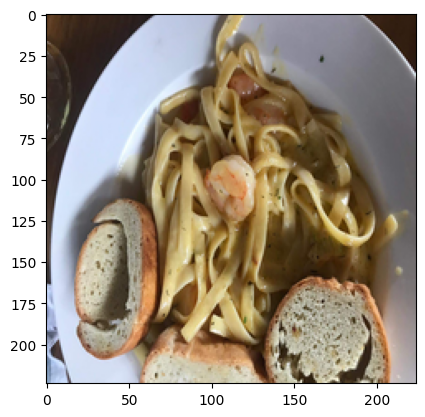

Predicted caption:
 grilled chicken and spring onions

demo_imgs/2.jpg: (224, 224, 3)
1/1 [==============================] - 0s 29ms/step


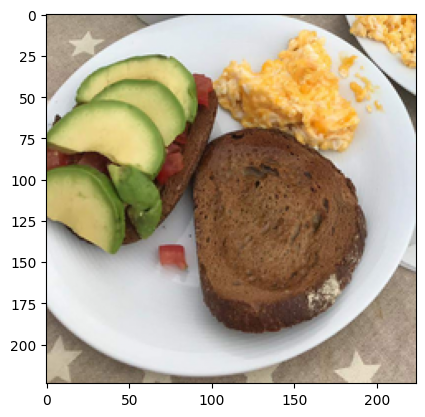

Predicted caption:
 cherry and coconut granola with yogurt

demo_imgs/3.jpg: (224, 224, 3)
1/1 [==============================] - 0s 24ms/step


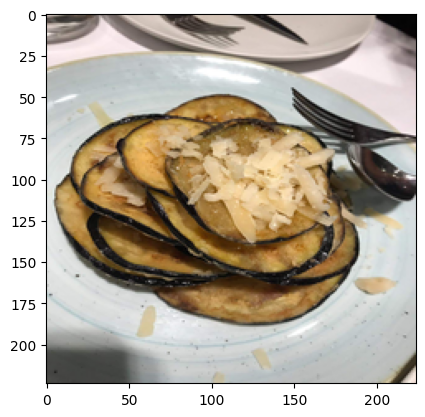

Predicted caption:
 dryrubbed turkey breast

demo_imgs/4.jpg: (224, 224, 3)
1/1 [==============================] - 0s 25ms/step


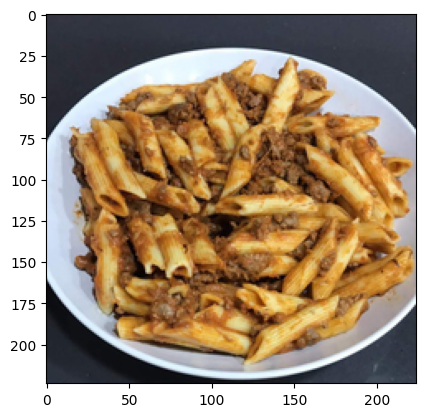

Predicted caption:
 grilled romanesco with anchovies and mint

demo_imgs/5.jpg: (224, 224, 3)
1/1 [==============================] - 0s 24ms/step


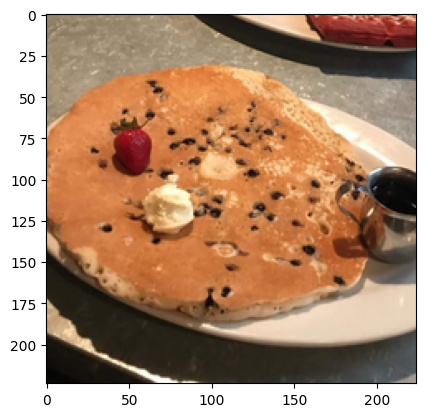

Predicted caption:
 cherry french chicken with lemon tomatoes

demo_imgs/6.jpg: (224, 224, 3)
1/1 [==============================] - 0s 37ms/step


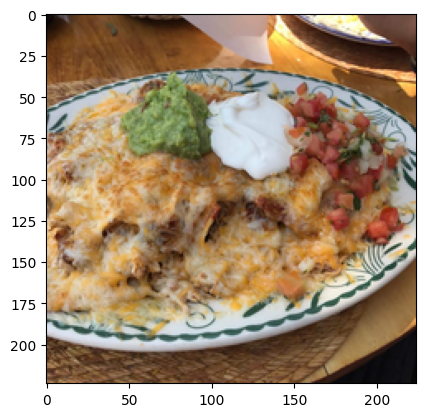

Predicted caption:
 salsa pie



In [66]:
demofiles = ["demo_imgs/1.jpg",
             "demo_imgs/2.jpg",
             "demo_imgs/3.jpg",
             "demo_imgs/4.jpg",
             "demo_imgs/5.jpg",
             "demo_imgs/6.jpg"]
for filename in demofiles:
  generate_caption(filename)

In [67]:
from sentence_transformers import SentenceTransformer, util
sentencemodel = SentenceTransformer('all-MiniLM-L6-v2')

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [68]:
def calc_cos_sim(sentence1, sentence2):
  em1 = sentencemodel.encode(sentence1, convert_to_tensor=True)
  em2 = sentencemodel.encode(sentence2, convert_to_tensor=True)

  return util.cos_sim(em1, em2).item()

calc_cos_sim('hello', 'hello')

1.0000001192092896

In [69]:
test_cos_sim = {}
test_generated_caption = {}
count = len(test_descriptions)
for i, (filename, original_caption) in enumerate(test_descriptions.items()):
  print(f"processing: {i} out of {count}")
  generated_caption = generate_just_caption('../Kaggle data/images/test/' + filename + '.jpg')
  cos_sim = calc_cos_sim(original_caption, generated_caption)
  test_cos_sim[filename] = cos_sim
  test_generated_caption[filename] = generated_caption

NameError: ignored

In [ ]:
with open('test_6layers_20epochs_cos_sim_original.pkl','wb') as f: pkl.dump(test_cos_sim, f)
with open('test_6layers_20epochs_generated_caption_original.pkl','wb') as f: pkl.dump(test_generated_caption, f)

In [70]:
with open('test_6layers_20epochs_cos_sim_original.pkl', 'rb') as handle:
    test_generated_caption = pkl.load(handle)

In [76]:
avg_cos_sim = sum(test_cos_sim.values()) / len(test_cos_sim)
print(avg_cos_sim)

0.29012405845073175


In [77]:
import statistics
statistics.stdev(test_cos_sim.values())

0.12228768493488958

In [ ]:
for filename in sorted(test_cos_sim, key=test_cos_sim.get, reverse=True)[:10]:
  print(f"Original Caption: {test_descriptions[filename]}")
  print(f"Generated Caption: {test_generated_caption[filename]}")
  print(f"Cosine Similarity: {test_cos_sim[filename]}")
  print()

Original Caption: negroni
Generated Caption:  negroni
Cosine Similarity: 1.0

Original Caption: sweet summer corn soup
Generated Caption:  roasted corn soup
Cosine Similarity: 0.8396082520484924

Original Caption: shamrock shake
Generated Caption:  rum matcha shamrock shake
Cosine Similarity: 0.8266215324401855

Original Caption: our favorite chocolate chip cookies
Generated Caption:  chewy chip cookies
Cosine Similarity: 0.7886237502098083

Original Caption: homemade marshmallows
Generated Caption:  without marshmallows
Cosine Similarity: 0.7707875967025757

Original Caption: salad for breakfast
Generated Caption:  roasted corn breakfast salad
Cosine Similarity: 0.7619936466217041

Original Caption: grilled skirt steak and pepper sandwiches with corn mayonnaise
Generated Caption:  grilled chicken sandwich with buttermilk slaw and artichoke mayo
Cosine Similarity: 0.7451901435852051

Original Caption: berries and rum
Generated Caption:  strawberries and vodka
Cosine Similarity: 0.73478